## 2D CNN

Outline of the notebook:

1. Get Data and Bring into Notebook
2. EDA
3. Create a dataset and a data loader
- sklearn standard scaler
- reshape data
4. Reproduce the 2D CNN
5. Define the code to train the Model
6. Train the model
7. View the results

### 1. Get Data and bring into Notebook

In [ ]:
# https://www.kaggle.com/code/nilslefeuvre/credit-card-fraud-detection-using-ml-dl  - undersampling
# https://www.kaggle.com/code/rahulmakwana/creditcard-fruad-detection-cnn-ann-and-regression smote sampling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.datasets import fetch_openml
import time
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data.sampler import SubsetRandomSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch import round
from sklearn.metrics import classification_report
import torch.optim as optim
from torch import round
from torch import ceil
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

### 2. EDA

284,807 Rows 
31 Columns

In [ ]:
df.shape

(284807, 31)

No Null Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time and Amount are disproportionately large as compared with V1 - V28

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Confirm Target Variable

,index,a
0,0,284315
1,1,492


In [ ]:
df1 = (df['Class'].value_counts()).reset_index()\
.replace({0: 'No Fraud', 1 : 'Fraud'}).rename(columns={'index': 'Transaction Type',
                                                       'Class': 'Count'}).copy()

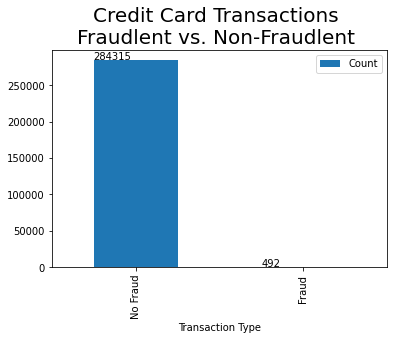

In [ ]:
# https://digestize.medium.com/how-to-add-counts-to-python-matplotlib-pandas-dataframe-bar-charts-15c26e3517f7
ax = df1.plot.bar(x='Transaction Type', y='Count')
plt.title('Credit Card Transactions \nFraudlent vs. Non-Fraudlent ',
          fontdict = {'fontsize' : 20})
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

### 3. Create a Dataset and a Dataloader

In [ ]:
class SimpleDataset(Dataset):
        
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        scaler = StandardScaler()
        # X.shape allows for different train sizes
        # scaler employs the standard scaler
        self.X = scaler.fit_transform(X).reshape((X.shape[0],1,5,6))  
        self.y = y
    
    def __getitem__(self, index):
        #This "work" could have gone in the constructor, but you should get into 
        inputs = torch.tensor(self.X[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets 

    def __len__(self):
        return self.X.shape[0]


### 4. Reproduce the 2D CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.Dropout(0.5),
                nn.ReLU(inplace=True))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.Dropout(0.5),
                nn.ReLU(inplace=True),)
        
        
        self.fc=nn.Sequential(
                nn.Linear(32*1*5*6,1),
                nn.Sigmoid(),
)
        
    def forward(self,x):
        """Method for Forward Prop"""
        #print('in size: ', x.shape)
        x=self.conv1(x)
        #print('conv1 size: ', x.shape)
        x=self.conv2(x)
        #print('conv2 size: ', x.shape)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# Instantiate the Model
model = CNN()

# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [ ]:
def print_dim(model, input_width, input_height):
  X = torch.rand(size=(16, 1, input_width, input_height), dtype=torch.float32)
  for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=960, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


### 5. Define the code to train the Model
### 6. Train the model

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=.1)

In [ ]:
# number of epochs to train the model
n_epochs = 5


score_funcs = {'accuracy': accuracy_score,
               'precision': precision_score,
               'recall': recall_score,
               'f1_score': f1_score}

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []



l_sampling_imbalances = [1,.1,0.04,0.02,0.005,0.00174] 
#imbal = 0.1
batch_size = 16
cnn_results = {}

# create a complete CNN
model = CNN()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Move model to GPU if available
if train_on_gpu: model.cuda()


for imbal in l_sampling_imbalances:
  undersample = RandomUnderSampler(sampling_strategy=imbal)
  print('imbal:', imbal)

  results = {'train accuracy': [],
               'train precision': [],
               'train recall': [],
               'train f1_score': []}

  #https://colab.research.google.com/drive/1a-IpL_cNHz9fqfmYmPAB_brqEJkXFKjY#scrollTo=UZDenP1n3aly
  cols = [col for col in df.columns if col != 'Class']    
  # original dataset X values
  X = df[cols]
  # original dataset y values
  y = df['Class']

  # Address class imblance
  X_under, y_under = undersample.fit_resample(X, y)

  # Create training/test data
  X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size= 0.20)

  #Now we can make a PyTorch dataset 
  dataset = SimpleDataset(X_train.values, y_train.values)

  #Set up the training loader, define the batch size
  training_loader = DataLoader(dataset=dataset, batch_size=batch_size)


  for epoch in range(1, n_epochs+1):
      print('epoch:', epoch)
      # keep track of training and validation loss
      train_loss = 0.0
      y_actual = np.empty((0)) 
      y_pred =   np.empty((0)) 
      ###################
      # train the model #
      ###################
      model.train()
      for data, target in tqdm(training_loader, desc='Train Batch', leave=False):
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda().float()
          target = target.view(-1, 1)
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = round(model(data)) #round
          # calculate the batch loss
          loss = criterion(output, target.float())
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # Update Train loss and accuracies
          train_loss += loss.item()*data.size(0)
          y_actual = np.append(y_actual, target.data[:,-1].cpu().numpy(), axis=0)
          y_pred = np.append(y_pred, output[:,-1].detach().cpu().numpy().astype('int32'), axis=0)
          
      for name, score_func in score_funcs.items():
        if (score_func == accuracy_score):
          results["train " + name].append( score_func(y_actual[:-1], y_pred[:-1]) )
        else:
          results["train " + name].append( score_func(y_actual[:-1], y_pred[:-1], 
                                                      average='binary',
                                                      pos_label=1,
                                                      zero_division=0) ) 



      # calculate average losses
      train_loss = train_loss/len(training_loader)
      train_losses.append(train_loss)
          
      # print training/validation statistics 
      print('Epoch: {} | Training Loss: {:.6f}'.format(
          epoch, train_loss))
      
      cnn_results[imbal] =  pd.DataFrame.from_dict(results)


imbal: 1
epoch: 1


Train Batch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 738.000000
epoch: 2


Train Batch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2 | Training Loss: 782.000000
epoch: 3


Train Batch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3 | Training Loss: 764.000000
epoch: 4


Train Batch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4 | Training Loss: 768.000000
epoch: 5


Train Batch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5 | Training Loss: 750.000000
imbal: 0.1
epoch: 1


Train Batch:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1049.077491
epoch: 2


Train Batch:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch: 2 | Training Loss: 1076.752768
epoch: 3


Train Batch:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch: 3 | Training Loss: 1080.073801
epoch: 4


Train Batch:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch: 4 | Training Loss: 1073.800738
epoch: 5


Train Batch:   0%|          | 0/271 [00:00<?, ?it/s]

Epoch: 5 | Training Loss: 1047.601476
imbal: 0.04
epoch: 1


Train Batch:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1108.125000
epoch: 2


Train Batch:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 2 | Training Loss: 1108.437500
epoch: 3


Train Batch:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 3 | Training Loss: 1093.281250
epoch: 4


Train Batch:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 4 | Training Loss: 1091.718750
epoch: 5


Train Batch:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 5 | Training Loss: 1112.968750
imbal: 0.02
epoch: 1


Train Batch:   0%|          | 0/1255 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 1104.541833
epoch: 2


Train Batch:   0%|          | 0/1255 [00:00<?, ?it/s]

Epoch: 2 | Training Loss: 1110.358566
epoch: 3


Train Batch:   0%|          | 0/1255 [00:00<?, ?it/s]

Epoch: 3 | Training Loss: 1110.597610
epoch: 4


Train Batch:   0%|          | 0/1255 [00:00<?, ?it/s]

Epoch: 4 | Training Loss: 1104.940239
epoch: 5


Train Batch:   0%|          | 0/1255 [00:00<?, ?it/s]

Epoch: 5 | Training Loss: 1108.605578


### 7. View the results

In [ ]:
cnn_results.keys()

dict_keys([1, 0.1, 0.04, 0.02])

In [ ]:
cnn_results

{1:    train accuracy  train precision  train recall  train f1_score
 0        0.620865         0.644628      0.580645        0.610966
 1        0.594148         0.608808      0.583127        0.595691
 2        0.599237         0.620219      0.563275        0.590377
 3        0.606870         0.625668      0.580645        0.602317
 4        0.605598         0.616541      0.610422        0.613466,
 0.1:    train accuracy  train precision  train recall  train f1_score
 0        0.542052         0.116033      0.622739        0.195617
 1        0.526571         0.108388      0.594315        0.183340
 2        0.545055         0.116764      0.622739        0.196654
 3        0.547597         0.121081      0.648579        0.204065
 4        0.543438         0.114133      0.607235        0.192150,
 0.04:    train accuracy  train precision  train recall  train f1_score
 0        0.521306         0.050888      0.642317        0.094305
 1        0.524042         0.050633      0.634761        0.0

The 2D CNN gives an accuracy score of around 0.62086 for the sampling ratio 1. The accuracy scores for the other sampling ratios are below 0.60.